In [20]:
from pathlib import Path

import conllu
import plotly.express as px
import pandas as pd
from scipy import stats
import numpy as np
import scikit_posthocs as sp
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


porttinari_gold_sents = conllu.parse(open("../multigenre/outputs/porttinari/model-31361v0k-v0/pt_porttinari-ud-test.conllu", encoding="utf-8").read())
dante_gold_sents = conllu.parse(open("../multigenre/outputs/dante/model-1b7kowrx-v0/pt_dante-ud-test.conllu", encoding="utf-8").read())
petrogold_gold_sents = conllu.parse(open("../multigenre/outputs/petrogold/model-2v9qux4u-v0/pt_petrogold-ud-test.conllu", encoding="utf-8").read())

models_preds = {}
for setting_name in Path("../tmp").iterdir():
    full_setting_name = setting_name.stem.replace("porttinari", "Porttinari")
    full_setting_name = full_setting_name.replace("dante", "DANTEStocks")
    full_setting_name = full_setting_name.replace("petrogold", "PetroGold")
    full_setting_name = full_setting_name.replace("_", " ")
    for exp_id in setting_name.iterdir():
        data = {}
        print("Processing ", full_setting_name, exp_id.stem)
        for exp_filename in exp_id.glob("*pred.conllu"):
            if "dante" in exp_filename.stem:
                data["DANTEStocks"] = conllu.parse(open(exp_filename, encoding="utf-8").read())
            elif "petrogold" in exp_filename.stem:
                data["PetroGold"] = conllu.parse(open(exp_filename, encoding="utf-8").read())
            else:
                data["Porttinari"] = conllu.parse(open(exp_filename, encoding="utf-8").read())
        if full_setting_name not in models_preds.keys():
            models_preds[full_setting_name] = []    
        models_preds[full_setting_name].append( data )


Processing  DANTEStocks model-19fciu72-v0
Processing  DANTEStocks model-1b7kowrx-v0
Processing  DANTEStocks model-2akpbr05-v0
Processing  DANTEStocks model-2l1q1co8-v0
Processing  DANTEStocks model-2vl5c8as-v0
Processing  DANTEStocks model-66omv4vd-v0
Processing  DANTEStocks model-hfcre0cn-v0
Processing  DANTEStocks model-o0ojeh3x-v0
Processing  DANTEStocks model-sm3hnlkk-v0
Processing  DANTEStocks model-tv4yte30-v0
Processing  DANTEStocks PetroGold model-1vwxg7v2-v0
Processing  DANTEStocks PetroGold model-216u2b9d-v0
Processing  DANTEStocks PetroGold model-25rt674h-v0
Processing  DANTEStocks PetroGold model-2kyu5jev-v0
Processing  DANTEStocks PetroGold model-3evjf8e7-v0
Processing  DANTEStocks PetroGold model-3h6mbbp2-v0
Processing  DANTEStocks PetroGold model-3lesa1b2-v0
Processing  DANTEStocks PetroGold model-bnm5t8fw-v0
Processing  DANTEStocks PetroGold model-suxb490l-v0
Processing  DANTEStocks PetroGold model-vlmx70y6-v0
Processing  PetroGold model-19jxdvv7-v0
Processing  PetroGol

In [21]:
for model_name in models_preds.keys():
    assert len(models_preds[model_name]) == 10, f"Error on {model_name} with {len(models_preds[model_name])} files."
    for exp in models_preds[model_name]:
        assert len(exp.keys()) == 3, f"Error, data object has {len(exp.keys())} keys, it was expected 3 keys"

In [22]:
def get_sent_errors(gold_sents, pred_sents) -> pd.DataFrame:
    data = {
        "sent_id": [],
        "errors": [],
    }
    for gold_sent, pred_sent in zip(gold_sents, pred_sents):
        errors = 0
        for gold_token, pred_token in zip(gold_sent, pred_sent):
            if isinstance(gold_token["id"], int):
                if gold_token["upos"] != pred_token["upos"]:
                    errors += 1
        data["sent_id"].append(gold_sent.metadata["sent_id"])
        data["errors"].append(errors)
    return pd.DataFrame(data)

def get_sent_level_acc(gold_sents, pred_sents) -> float:
    total = len(gold_sents)
    total_match = 0
    for gold_sent, pred_sent in zip(gold_sents, pred_sents):
        errors = 0
        for gold_token, pred_token in zip(gold_sent, pred_sent):
            if isinstance(gold_token["id"], int):
                if gold_token["upos"] != pred_token["upos"]:
                    errors += 1
        if errors == 0:
            total_match += 1
    return total_match / total

results = {
    "model_name": [],
    "id": [],
    "Porttinari": [],
    "DANTEStocks": [],
    "PetroGold": [],
}
for model_name in models_preds.keys():
    for i, experiment in enumerate(models_preds[model_name]):
        porttinari_acc = get_sent_level_acc(porttinari_gold_sents, experiment["Porttinari"])
        dante_acc = get_sent_level_acc(dante_gold_sents, experiment["DANTEStocks"])
        petrogold_acc = get_sent_level_acc(petrogold_gold_sents, experiment["PetroGold"])
        results["model_name"].append(model_name)
        results["id"].append(i)
        results["Porttinari"].append(porttinari_acc)
        results["DANTEStocks"].append(dante_acc)
        results["PetroGold"].append(petrogold_acc)

results_df = pd.DataFrame(results)

In [23]:
results_df

,model_name,id,Porttinari,DANTEStocks,PetroGold
0,DANTEStocks,0,0.548561,0.714464,0.341573
1,DANTEStocks,1,0.583333,0.734414,0.366292
2,DANTEStocks,2,0.570743,0.719451,0.350562
3,DANTEStocks,3,0.556954,0.728180,0.348315
4,DANTEStocks,4,0.566547,0.731920,0.359551
...,...,...,...,...,...
65,Porttinari PetroGold,5,0.818345,0.048628,0.800000
66,Porttinari PetroGold,6,0.794964,0.054863,0.761798
67,Porttinari PetroGold,7,0.818345,0.051122,0.770787
68,Porttinari PetroGold,8,0.825540,0.058603,0.788764


In [24]:
results_df.groupby("model_name").mean()

,id,Porttinari,DANTEStocks,PetroGold
model_name,,,,
DANTEStocks,4.5,0.548681,0.724688,0.354157
DANTEStocks PetroGold,4.5,0.672422,0.723441,0.787865
PetroGold,4.5,0.570024,0.062344,0.788539
Porttinari,4.5,0.838249,0.098130,0.459326
Porttinari DANTEStocks,4.5,0.834353,0.733292,0.481798
Porttinari DANTEStocks PetroGold,4.5,0.826379,0.723192,0.781573
Porttinari PetroGold,4.5,0.817206,0.059975,0.773258


In [25]:
results_df.groupby("model_name").std()

,id,Porttinari,DANTEStocks,PetroGold
model_name,,,,
DANTEStocks,3.02765,0.022123,0.008055,0.011517
DANTEStocks PetroGold,3.02765,0.009228,0.005049,0.012632
PetroGold,3.02765,0.010372,0.007573,0.007672
Porttinari,3.02765,0.006829,0.007103,0.015826
Porttinari DANTEStocks,3.02765,0.005444,0.010587,0.016142
Porttinari DANTEStocks PetroGold,3.02765,0.008703,0.012017,0.009639
Porttinari PetroGold,3.02765,0.008644,0.007375,0.015693


In [34]:
import statsmodels.stats.multicomp as multi

def get_tukey_df(df, target_col, model_col="model_name", alpha=0.05):
    mcDate = multi.MultiComparison(df[target_col], df[model_col])
    Results = mcDate.tukeyhsd(alpha=alpha)
    other_df = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
    modelos = df[model_col].unique()
    new_df = pd.DataFrame([[0]*len(modelos)] * len(modelos), columns=modelos, index=modelos)
    for modelo in modelos:
        new_df.loc[modelo, modelo] = "-"
    for i, row in other_df.iterrows():
        new_df.loc[row["group1"], row["group2"]] = row["p-adj"]
        new_df.loc[row["group2"], row["group1"]] = row["p-adj"]
    return new_df.style.apply(lambda x: ["background: red" if isinstance(v, float) and v < alpha else "" for v in x], axis = 1)

Analysing results for Porttinari
Anova analysis:
F_onewayResult(statistic=1300.103332366676, pvalue=4.968727804384014e-64)


,DANTEStocks,DANTEStocks PetroGold,PetroGold,Porttinari,Porttinari DANTEStocks,Porttinari DANTEStocks PetroGold,Porttinari PetroGold
DANTEStocks,-,0.000000,0.001700,0.000000,0.000000,0.000000,0.000000
DANTEStocks PetroGold,0.000000,-,0.000000,0.000000,0.000000,0.000000,0.000000
PetroGold,0.001700,0.000000,-,0.000000,0.000000,0.000000,0.000000
Porttinari,0.000000,0.000000,0.000000,-,0.987500,0.246600,0.002000
Porttinari DANTEStocks,0.000000,0.000000,0.000000,0.987500,-,0.704700,0.021100
Porttinari DANTEStocks PetroGold,0.000000,0.000000,0.000000,0.246600,0.704700,-,0.553000
Porttinari PetroGold,0.000000,0.000000,0.000000,0.002000,0.021100,0.553000,-


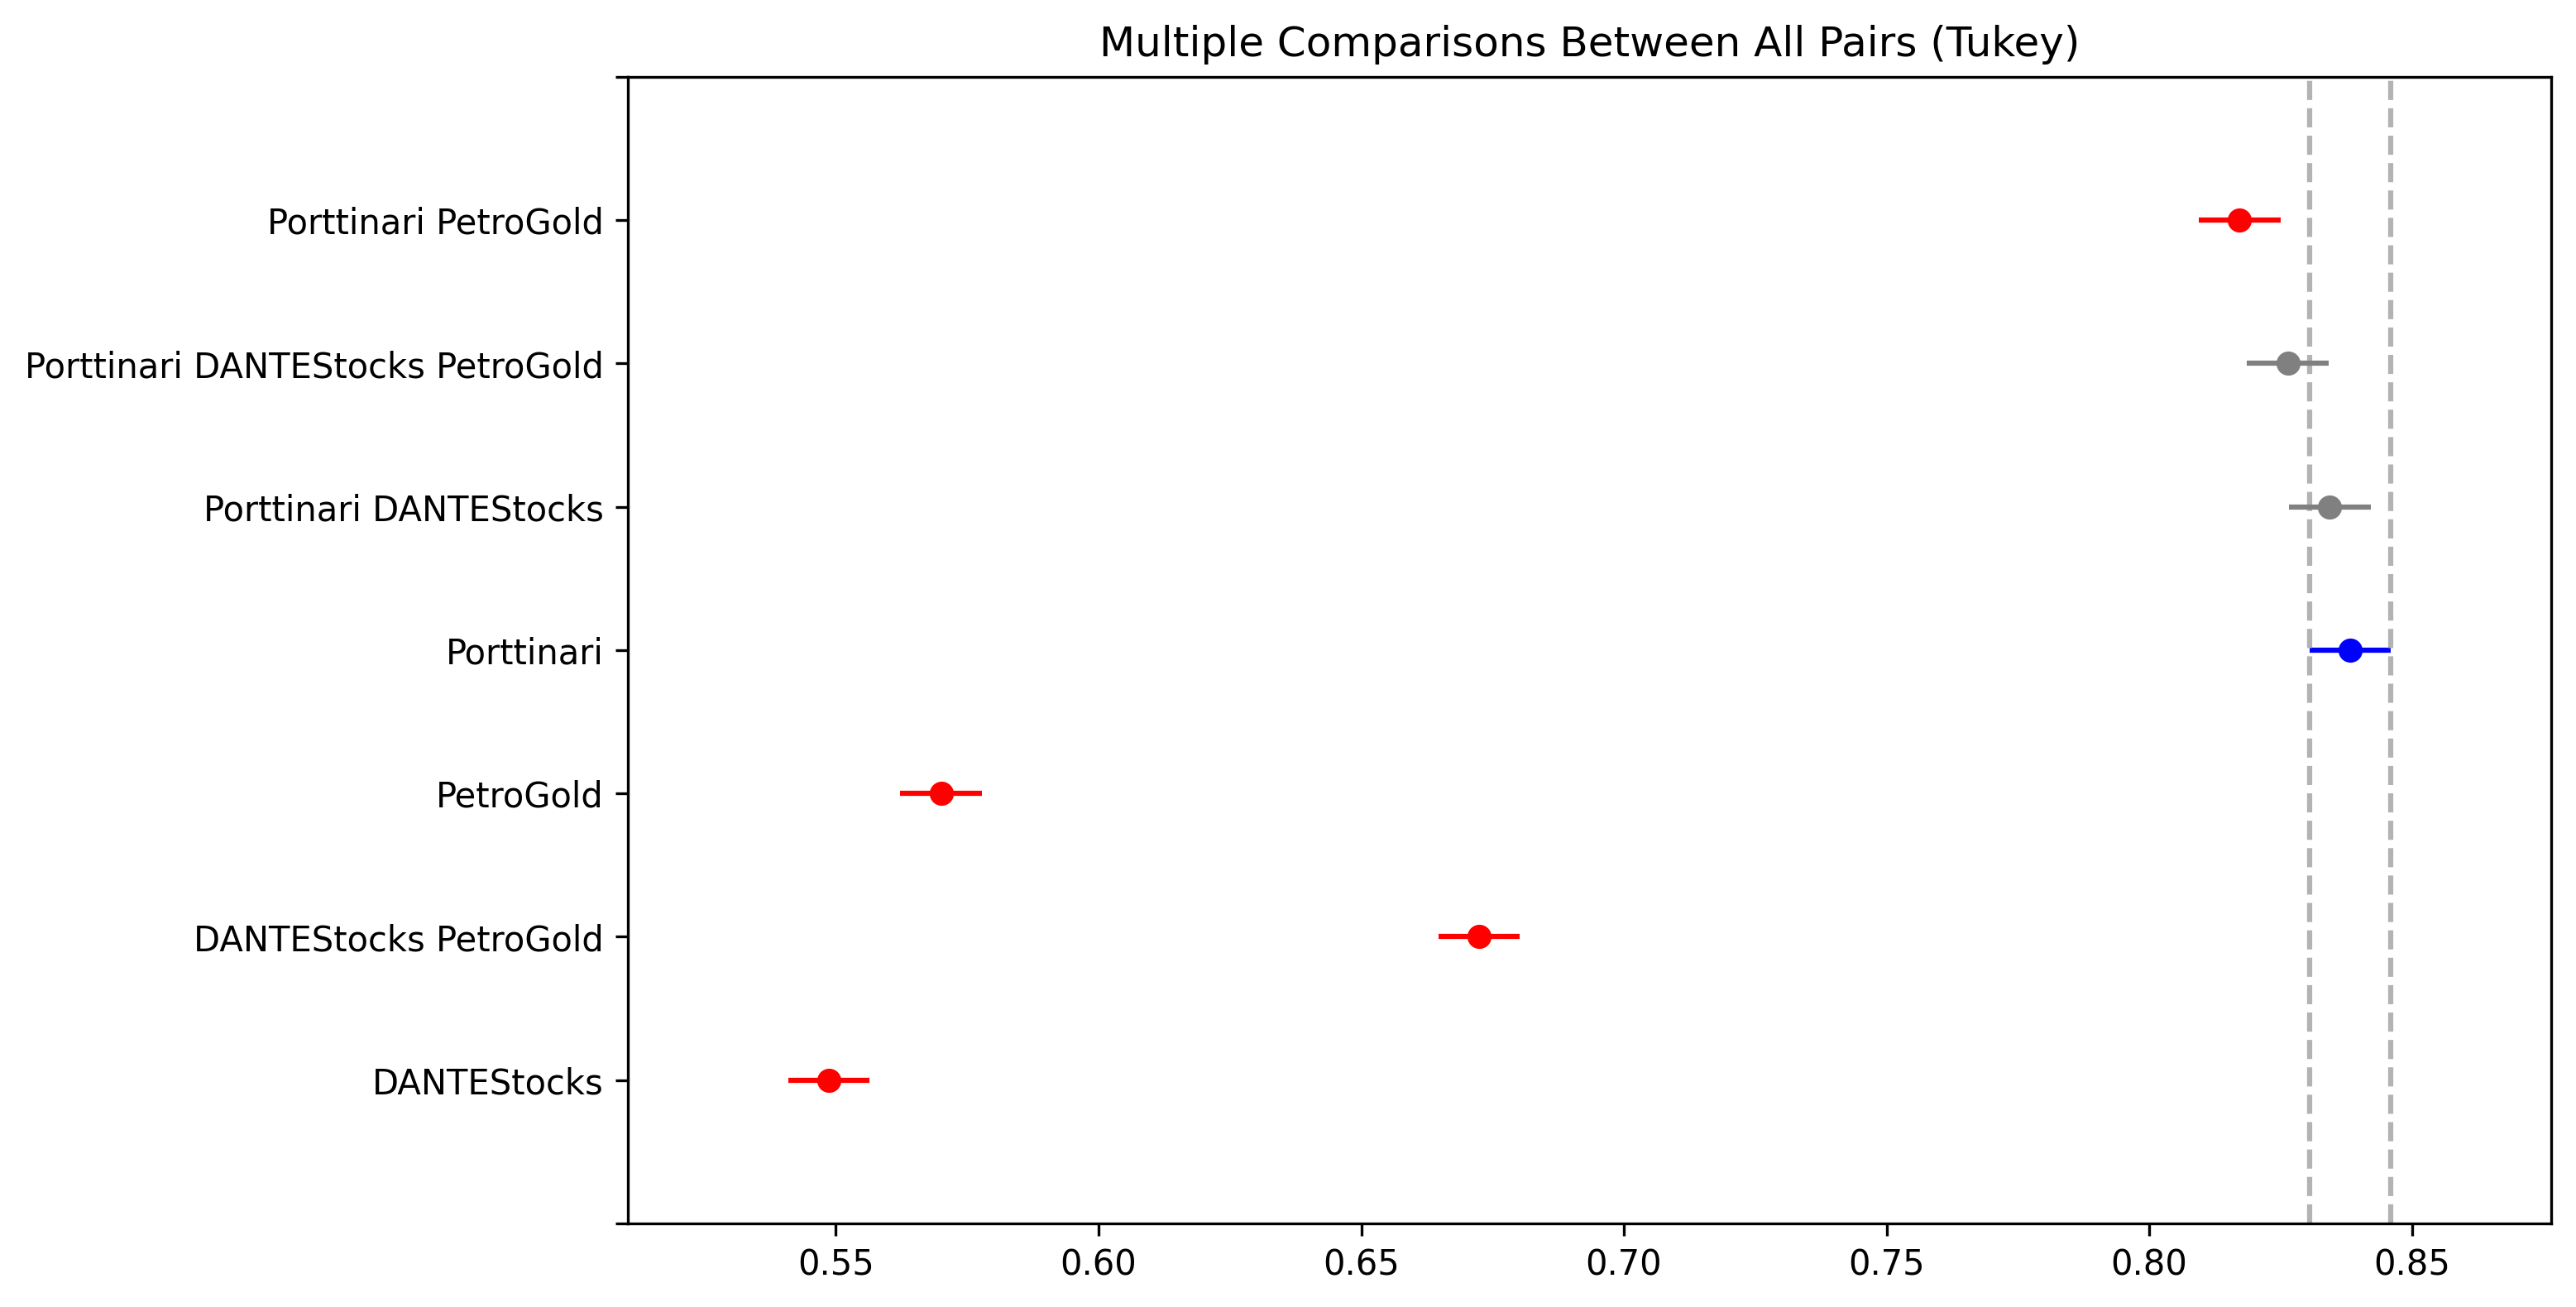

In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

target = "Porttinari"
results = []
for model_name in results_df["model_name"].unique():
    results.append( results_df[results_df["model_name"] == model_name][target].values )

print("Analysing results for Porttinari")
print("Anova analysis:")
print(f_oneway(*results))

tukey = pairwise_tukeyhsd(endog=results_df['Porttinari'],
                          groups=results_df['model_name'],
                          alpha=0.05)
# print(tukey)
fig1 = tukey.plot_simultaneous("Porttinari")
display(get_tukey_df(results_df, "Porttinari"))

Analysing results for DANTEStocks
Anova analysis:
F_onewayResult(statistic=16757.088527702446, pvalue=6.79218647843329e-99)


,DANTEStocks,DANTEStocks PetroGold,PetroGold,Porttinari,Porttinari DANTEStocks,Porttinari DANTEStocks PetroGold,Porttinari PetroGold
DANTEStocks,-,0.999900,0.000000,0.000000,0.281700,0.999700,0.000000
DANTEStocks PetroGold,0.999900,-,0.000000,0.000000,0.148900,1.000000,0.000000
PetroGold,0.000000,0.000000,-,0.000000,0.000000,0.000000,0.995900
Porttinari,0.000000,0.000000,0.000000,-,0.000000,0.000000,0.000000
Porttinari DANTEStocks,0.281700,0.148900,0.000000,0.000000,-,0.129300,0.000000
Porttinari DANTEStocks PetroGold,0.999700,1.000000,0.000000,0.000000,0.129300,-,0.000000
Porttinari PetroGold,0.000000,0.000000,0.995900,0.000000,0.000000,0.000000,-


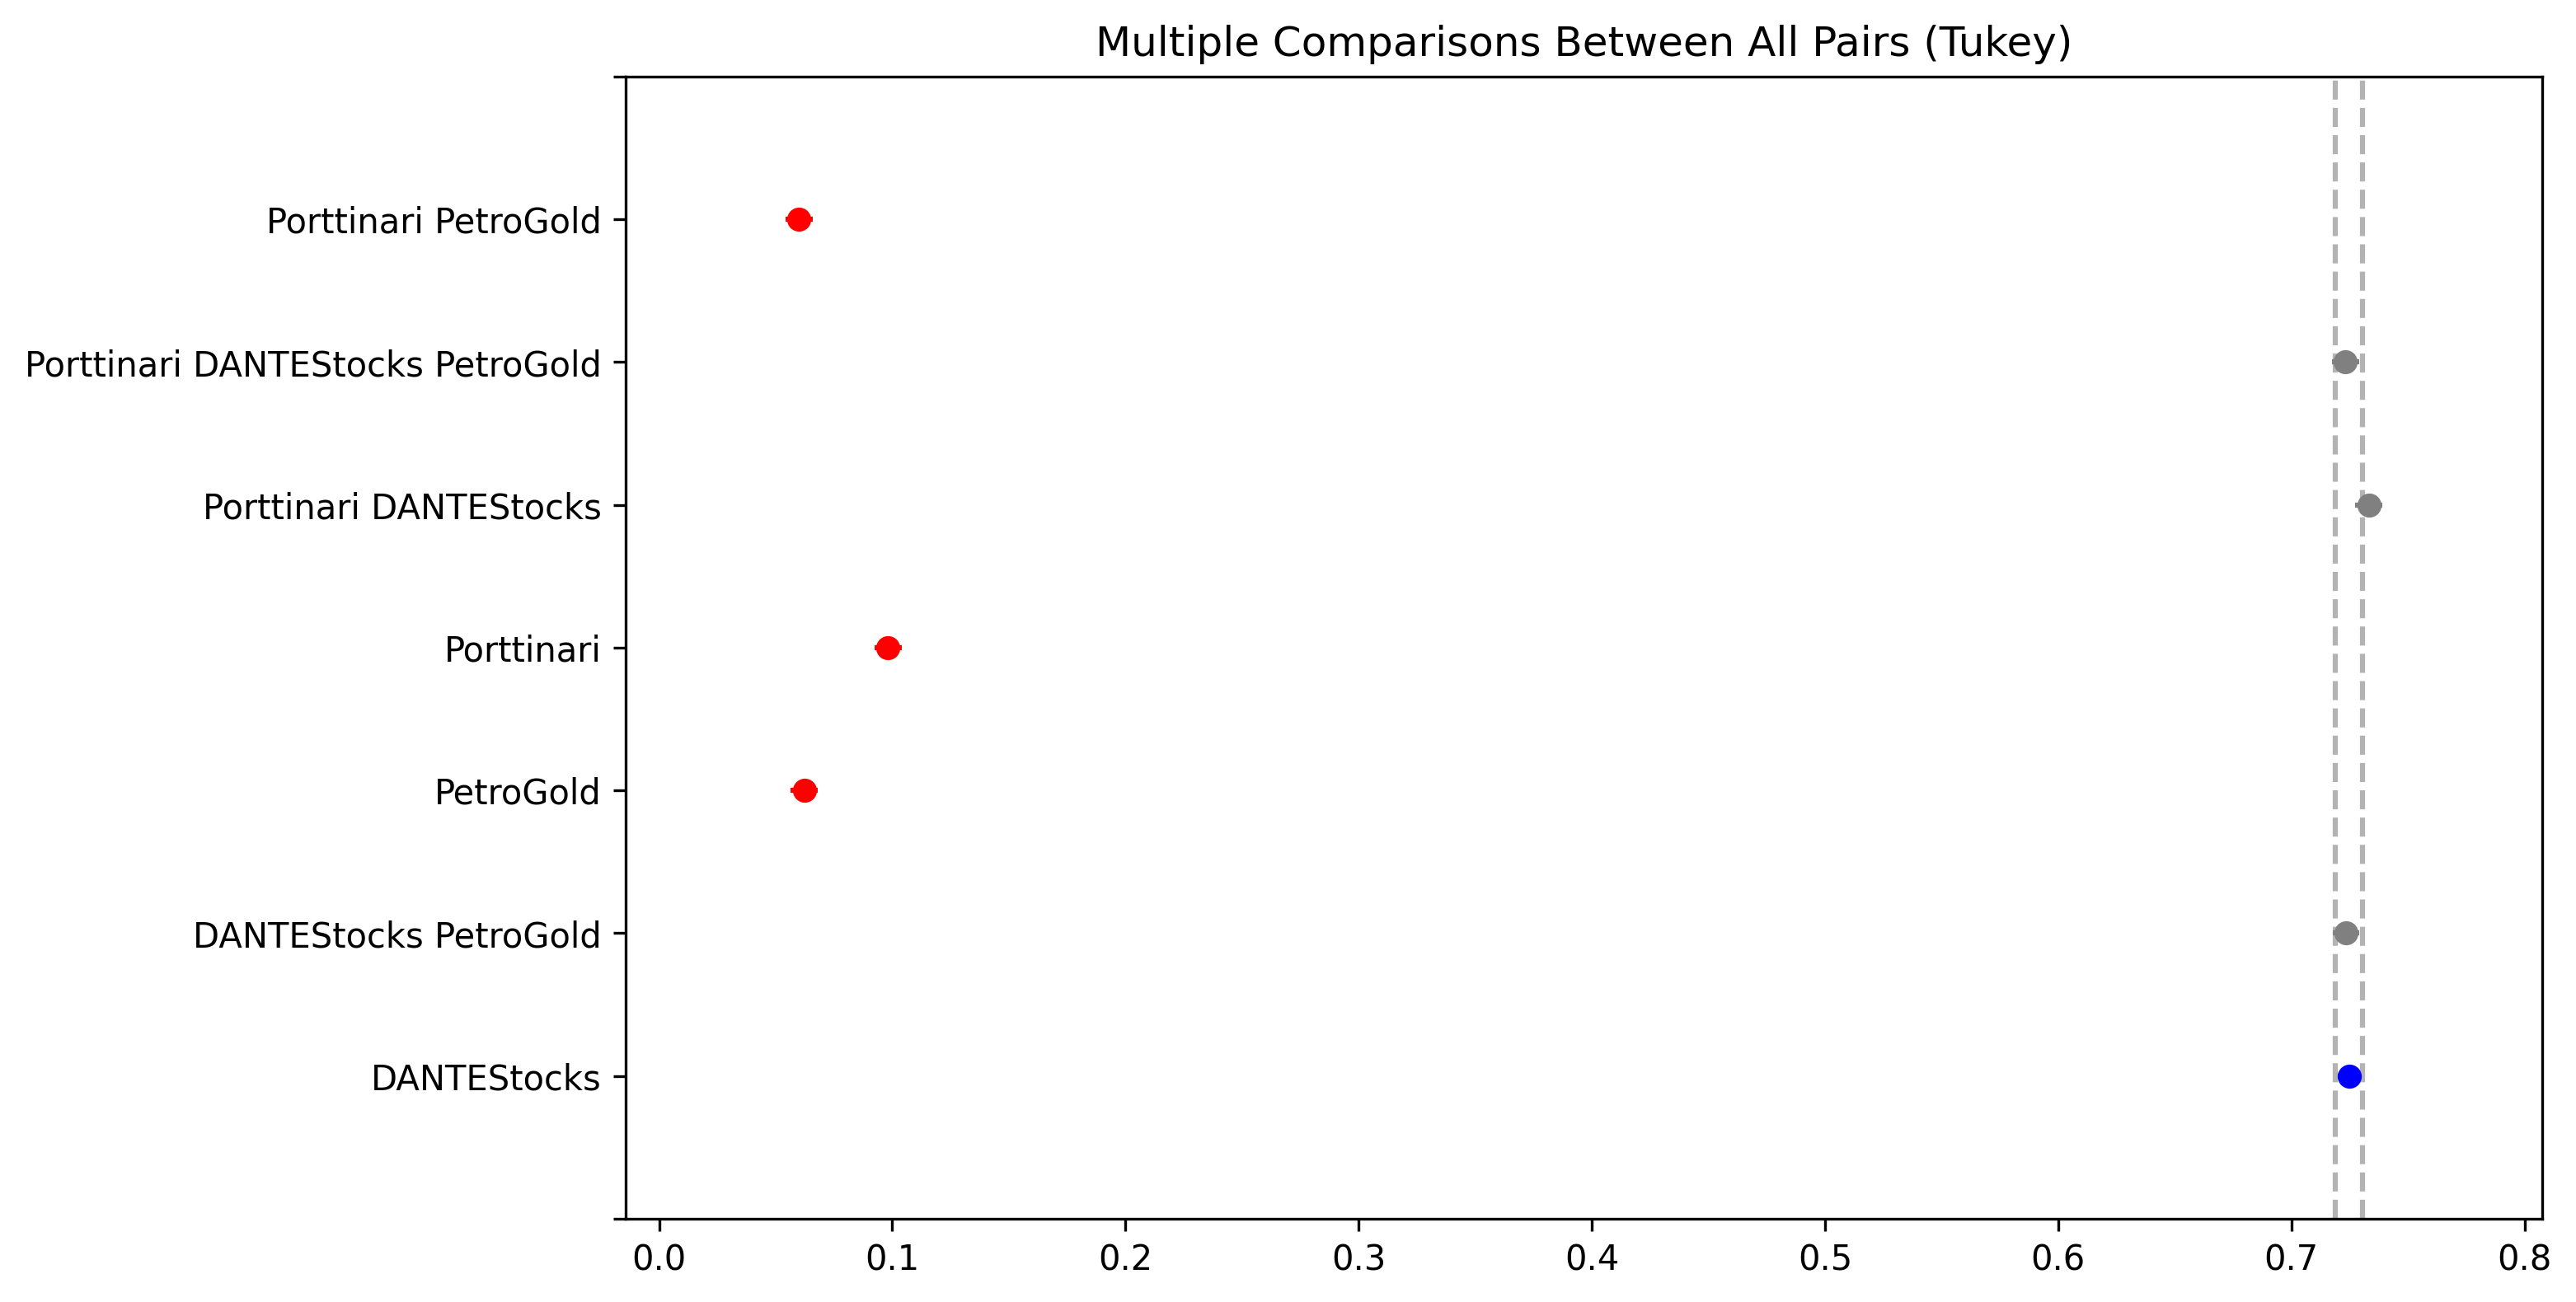

In [39]:
target = "DANTEStocks"
results = []
for model_name in results_df["model_name"].unique():
    results.append( results_df[results_df["model_name"] == model_name][target].values )

print("Analysing results for", target)
print("Anova analysis:")
print(f_oneway(*results))

tukey = pairwise_tukeyhsd(endog=results_df[target],
                          groups=results_df['model_name'],
                          alpha=0.05)
# print(tukey)
fig1 = tukey.plot_simultaneous(target)
display(get_tukey_df(results_df, target))

Analysing results for PetroGold
Anova analysis:
F_onewayResult(statistic=2143.332975245199, pvalue=7.999605733123603e-71)


,DANTEStocks,DANTEStocks PetroGold,PetroGold,Porttinari,Porttinari DANTEStocks,Porttinari DANTEStocks PetroGold,Porttinari PetroGold
DANTEStocks,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DANTEStocks PetroGold,0.000000,-,1.000000,0.000000,0.000000,0.933400,0.179400
PetroGold,0.000000,1.000000,-,0.000000,0.000000,0.895700,0.141000
Porttinari,0.000000,0.000000,0.000000,-,0.005200,0.000000,0.000000
Porttinari DANTEStocks,0.000000,0.000000,0.000000,0.005200,-,0.000000,0.000000
Porttinari DANTEStocks PetroGold,0.000000,0.933400,0.895700,0.000000,0.000000,-,0.789500
Porttinari PetroGold,0.000000,0.179400,0.141000,0.000000,0.000000,0.789500,-


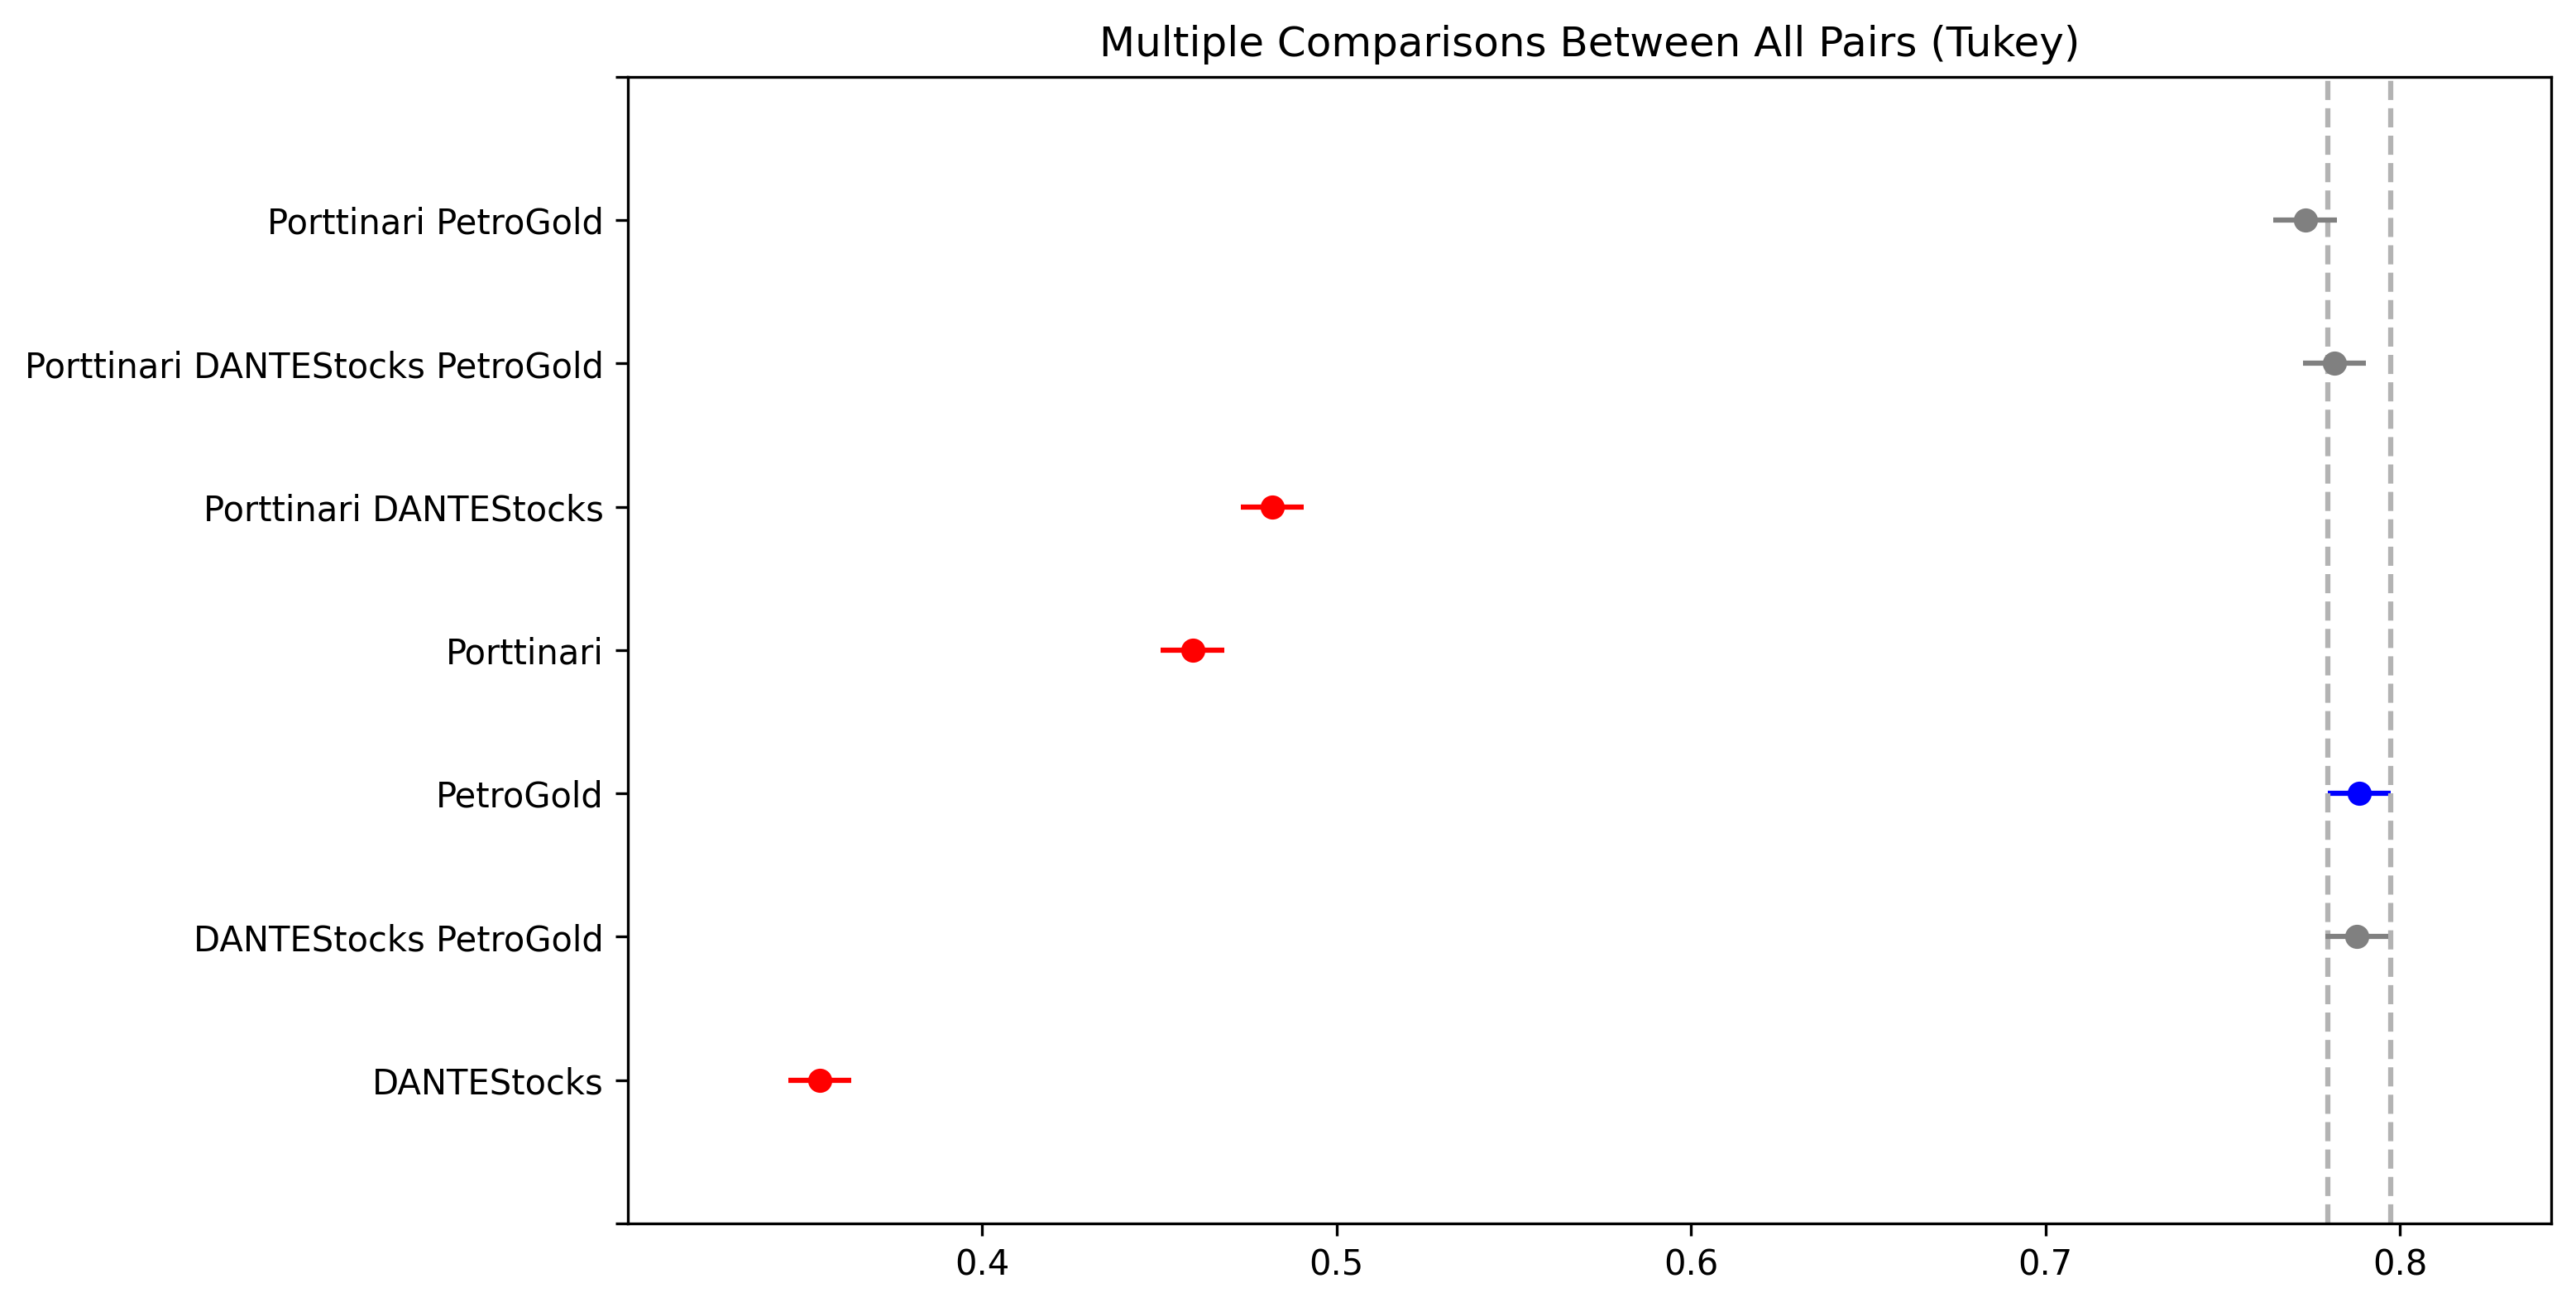

In [38]:
target = "PetroGold"
results = []
for model_name in results_df["model_name"].unique():
    results.append( results_df[results_df["model_name"] == model_name][target].values )

print("Analysing results for", target)
print("Anova analysis:")
print(f_oneway(*results))

tukey = pairwise_tukeyhsd(endog=results_df[target],
                          groups=results_df['model_name'],
                          alpha=0.05)
# print(tukey)
fig1 = tukey.plot_simultaneous(target)
display(get_tukey_df(results_df, target))

KeyError: 'Modelo'

In [3]:
porttinari_gold_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_porttinari-ud-test.conllu", encoding="utf-8").read())
porttinari_pred_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())
dante_pred_sents = conllu.parse(open("../tmp/dante/model-1b7kowrx-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())
petrogold_pred_sents = conllu.parse(open("../tmp/petrogold/model-2v9qux4u-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())
multi_pred_sents = conllu.parse(open("../tmp/porttinari_dante_petrogold/model-3nr9mytc-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())

porttinari_df = get_sent_errors(porttinari_gold_sents, porttinari_pred_sents)
dante_df = get_sent_errors(porttinari_gold_sents, dante_pred_sents)
petrogold_df = get_sent_errors(porttinari_gold_sents, petrogold_pred_sents)
multi_df = get_sent_errors(porttinari_gold_sents, multi_pred_sents)

porttinari_df["Modelo"] = "porttinari"
dante_df["Modelo"] = "dante"
petrogold_df["Modelo"] = "petrogold"
multi_df["Modelo"] = "Multigênero"


for name, df in zip([
    "Porttinari", "DANTE", "PetroGold", "Multigênero"
], [porttinari_df, dante_df, petrogold_df, multi_df]):
    display(name)
    display(df["errors"].value_counts()/df.shape[0])

final_df = porttinari_df.append(dante_df, ignore_index=True).append(petrogold_df, ignore_index=True).append(multi_df, ignore_index=True)

# new_df = 
fig = px.histogram(final_df, x="errors", barmode="group", color="Modelo", width=800, height=400)
fig.write_image("porttinari_errors.png", scale=2)
fig.show()

'Porttinari'

0    0.845324
1    0.132494
2    0.020384
3    0.001799
Name: errors, dtype: float64

'DANTE'

0     0.583333
1     0.281175
2     0.094125
3     0.027578
4     0.006595
5     0.004796
6     0.001199
8     0.000600
13    0.000600
Name: errors, dtype: float64

'PetroGold'

0    0.552158
1    0.314748
2    0.099520
3    0.022782
4    0.007194
5    0.003597
Name: errors, dtype: float64

'Multigênero'

0    0.832734
1    0.142686
2    0.023381
3    0.001199
Name: errors, dtype: float64

C:\Users\huber\AppData\Local\Temp\ipykernel_18348\4156056772.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = porttinari_df.append(dante_df, ignore_index=True).append(petrogold_df, ignore_index=True).append(multi_df, ignore_index=True)


In [4]:
for sent_id in dante_df[dante_df["errors"] > 6]["sent_id"]:
    for true_sent in porttinari_gold_sents:
        if true_sent.metadata["sent_id"] == sent_id:
            for sent in dante_pred_sents:
                if sent.metadata["sent_id"] == sent_id:
                    print(sent.metadata["sent_id"])
                    for pred_token, gold_token in zip(sent, true_sent):
                        print("{}\t{}\t{}".format(pred_token["form"], gold_token["upos"], pred_token["upos"]))
    print()

FOLHA_DOC003071_SENT011
Em	ADP	ADP
um	NUM	DET
dos	_	_
de	ADP	ADP
os	DET	DET
momentos	NOUN	NOUN
dignos	ADJ	ADJ
de	ADP	ADP
menção	NOUN	NOUN
,	PUNCT	PUNCT
a	DET	DET
backing	X	NOUN
vocal	X	X
Whitney	PROPN	PROPN
se	PRON	PRON
esgoelou	VERB	VERB
ao	_	_
a	ADP	ADP
o	DET	DET
cantar	VERB	VERB
"	PUNCT	PUNCT
How	PROPN	INTJ
Come	PROPN	VERB
You	PROPN	PRON
Dont	PROPN	X
Call	PROPN	X
Me	PROPN	PRON
"	PUNCT	PUNCT
e	CCONJ	CCONJ
foi	AUX	AUX
ovacionada	VERB	VERB
.	PUNCT	PUNCT

FOLHA_DOC003084_SENT009
Abriu	VERB	VERB
com	ADP	ADP
"	PUNCT	PUNCT
I've	PROPN	SYM
Got	PROPN	X
You	PROPN	PRON
Under	PROPN	ADP
My	PROPN	DET
Skin	PROPN	PROPN
"	PUNCT	PUNCT
e	CCONJ	CCONJ
teve	VERB	VERB
ótimos	ADJ	ADJ
momentos	NOUN	NOUN
,	PUNCT	PUNCT
como	ADP	ADP
"	PUNCT	PUNCT
The	PROPN	DET
Lady	PROPN	NOUN
is	X	AUX
a	X	DET
Tramp	PROPN	NOUN
"	PUNCT	PUNCT
e	CCONJ	CCONJ
"	PUNCT	PUNCT
They	PROPN	X
Can't	PROPN	X
Take	PROPN	VERB
"	PUNCT	PUNCT
.	PUNCT	PUNCT



In [6]:
dante_gold_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_dante-ud-test.conllu", encoding="utf-8").read())
porttinari_pred_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_dante-ud-test_pred.conllu", encoding="utf-8").read())
# dante_gold_sents = conllu.parse(open("../tmp/dante/model-1b7kowrx-v0/pt_dante-ud-test.conllu", encoding="utf-8").read())
dante_pred_sents = conllu.parse(open("../tmp/dante/model-1b7kowrx-v0/pt_dante-ud-test_pred.conllu", encoding="utf-8").read())
# petrogold_gold_sents = conllu.parse(open("../tmp/petrogold/model-2v9qux4u-v0/pt_petrogold-ud-test.conllu", encoding="utf-8").read())
petrogold_pred_sents = conllu.parse(open("../tmp/petrogold/model-2v9qux4u-v0/pt_dante-ud-test_pred.conllu", encoding="utf-8").read())
multi_pred_sents = conllu.parse(open("../tmp/porttinari_dante_petrogold/model-3nr9mytc-v0/pt_dante-ud-test_pred.conllu", encoding="utf-8").read())

porttinari_df = get_sent_errors(dante_gold_sents, porttinari_pred_sents)
dante_df = get_sent_errors(dante_gold_sents, dante_pred_sents)
petrogold_df = get_sent_errors(dante_gold_sents, petrogold_pred_sents)
multi_df = get_sent_errors(dante_gold_sents, multi_pred_sents)

porttinari_df["Modelo"] = "porttinari"
dante_df["Modelo"] = "dante"
petrogold_df["Modelo"] = "petrogold"
multi_df["Modelo"] = "Multigênero"
dante_final_df = porttinari_df.append(dante_df, ignore_index=True).append(petrogold_df, ignore_index=True).append(multi_df, ignore_index=True)

for name, df in zip([
    "Porttinari", "DANTE", "PetroGold", "Multigênero"
], [porttinari_df, dante_df, petrogold_df, multi_df]):
    display(name)
    display(df["errors"].value_counts()/df.shape[0])


# new_df = 
fig = px.histogram(dante_final_df, x="errors", barmode="group", color="Modelo", width=800, height=400)
fig.write_image("dante_errors.png", scale=2)

C:\Users\huber\AppData\Local\Temp\ipykernel_13656\999843325.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



'Porttinari'

1     0.273067
2     0.238155
3     0.167082
0     0.107232
4     0.098504
5     0.063591
6     0.019950
7     0.013716
8     0.008728
9     0.004988
10    0.002494
11    0.001247
12    0.001247
Name: errors, dtype: float64

'DANTE'

0    0.734414
1    0.189526
2    0.058603
3    0.012469
4    0.002494
5    0.001247
7    0.001247
Name: errors, dtype: float64

'PetroGold'

2     0.240648
1     0.185786
3     0.158354
4     0.120948
5     0.115960
0     0.062344
6     0.059850
7     0.031172
8     0.009975
9     0.008728
10    0.006234
Name: errors, dtype: float64

'Multigênero'

0    0.724439
1    0.194514
2    0.067332
4    0.006234
3    0.006234
8    0.001247
Name: errors, dtype: float64

In [9]:
petrogold_gold_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_petrogold-ud-test.conllu", encoding="utf-8").read())
porttinari_pred_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_petrogold-ud-test_pred.conllu", encoding="utf-8").read())
dante_pred_sents = conllu.parse(open("../tmp/dante/model-1b7kowrx-v0/pt_petrogold-ud-test_pred.conllu", encoding="utf-8").read())
petrogold_pred_sents = conllu.parse(open("../tmp/petrogold/model-2v9qux4u-v0/pt_petrogold-ud-test_pred.conllu", encoding="utf-8").read())
multi_pred_sents = conllu.parse(open("../tmp/porttinari_dante_petrogold/model-3nr9mytc-v0/pt_petrogold-ud-test_pred.conllu", encoding="utf-8").read())

porttinari_df = get_sent_errors(petrogold_gold_sents, porttinari_pred_sents)
dante_df = get_sent_errors(petrogold_gold_sents, dante_pred_sents)
petrogold_df = get_sent_errors(petrogold_gold_sents, petrogold_pred_sents)
multi_df = get_sent_errors(petrogold_gold_sents, multi_pred_sents)

porttinari_df["Modelo"] = "porttinari"
dante_df["Modelo"] = "dante"
petrogold_df["Modelo"] = "petrogold"
multi_df["Modelo"] = "Multigênero"
petrogold_final_df = porttinari_df.append(dante_df, ignore_index=True).append(petrogold_df, ignore_index=True).append(multi_df, ignore_index=True)

for name, df in zip([
    "Porttinari", "DANTE", "PetroGold", "Multigênero"
], [porttinari_df, dante_df, petrogold_df, multi_df]):
    display(name)
    display(df["errors"].value_counts()/df.shape[0])


# new_df = 
fig = px.histogram(petrogold_final_df, x="errors", barmode="group", color="Modelo", width=800, height=400)
fig.write_image("petrogold_errors.png", scale=2)

C:\Users\huber\AppData\Local\Temp\ipykernel_13656\2564969724.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



'Porttinari'

0     0.483146
1     0.269663
2     0.152809
3     0.056180
4     0.024719
5     0.011236
17    0.002247
Name: errors, dtype: float64

'DANTE'

0     0.366292
1     0.289888
2     0.188764
3     0.078652
4     0.035955
5     0.022472
7     0.011236
6     0.004494
17    0.002247
Name: errors, dtype: float64

'PetroGold'

0     0.802247
1     0.141573
2     0.042697
3     0.006742
4     0.004494
14    0.002247
Name: errors, dtype: float64

'Multigênero'

0     0.782022
1     0.150562
2     0.044944
3     0.015730
4     0.004494
13    0.002247
Name: errors, dtype: float64

In [36]:
petrogold_gold_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_porttinari-ud-test.conllu", encoding="utf-8").read())
porttinari_pred_sents = conllu.parse(open("../tmp/porttinari/model-31361v0k-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())
dante_pred_sents = conllu.parse(open("../tmp/dante/model-1b7kowrx-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())
petrogold_pred_sents = conllu.parse(open("../tmp/petrogold/model-2v9qux4u-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())
multi_pred_sents = conllu.parse(open("../tmp/dante_petrogold/model-3h6mbbp2-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())

porttinari_df = get_sent_errors(petrogold_gold_sents, porttinari_pred_sents)
dante_df = get_sent_errors(petrogold_gold_sents, dante_pred_sents)
petrogold_df = get_sent_errors(petrogold_gold_sents, petrogold_pred_sents)
multi_df = get_sent_errors(petrogold_gold_sents, multi_pred_sents)

porttinari_df["Modelo"] = "porttinari"
dante_df["Modelo"] = "dante"
petrogold_df["Modelo"] = "petrogold"
multi_df["Modelo"] = "Multigênero"
petrogold_final_df = porttinari_df.append(dante_df, ignore_index=True).append(petrogold_df, ignore_index=True).append(multi_df, ignore_index=True)

for name, df in zip([
    "Porttinari", "DANTE", "PetroGold", "Multigênero"
], [porttinari_df, dante_df, petrogold_df, multi_df]):
    display(name)
    display(df["errors"].value_counts()/df.shape[0])


# new_df = 
px.histogram(petrogold_final_df, x="errors", barmode="group", color="Modelo")

C:\Users\huber\AppData\Local\Temp\ipykernel_24152\1427098668.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



'Porttinari'

0    0.845324
1    0.132494
2    0.020384
3    0.001799
Name: errors, dtype: float64

'DANTE'

0     0.583333
1     0.281175
2     0.094125
3     0.027578
4     0.006595
5     0.004796
6     0.001199
8     0.000600
13    0.000600
Name: errors, dtype: float64

'PetroGold'

0    0.552158
1    0.314748
2    0.099520
3    0.022782
4    0.007194
5    0.003597
Name: errors, dtype: float64

'Multigênero'

0    0.684652
1    0.233213
2    0.065947
3    0.013789
4    0.002398
Name: errors, dtype: float64

### Porttinari

In [3]:
porttinari_total_correct = porttinari_df[porttinari_df["errors"] == 0].shape[0]
print("Total percentage of totally correct sentences: {:.10f}%".format(100*porttinari_total_correct/porttinari_df.shape[0]))
display(porttinari_df["errors"].value_counts() / porttinari_df.shape[0])
px.histogram(porttinari_df, x="errors")

Total percentage of totally correct sentences: 84.5323741007%


0    0.845324
1    0.132494
2    0.020384
3    0.001799
Name: errors, dtype: float64

### DANTE

In [36]:
dante_total_correct = dante_df[dante_df["errors"] == 0].shape[0]
print("Total percentage of totally correct sentences: {:.4f}%".format(100*dante_total_correct/dante_df.shape[0]))
display(dante_df["errors"].value_counts() / dante_df.shape[0])
px.histogram(dante_df, x="errors")

Total percentage of totally correct sentences: 73.4414%


0    0.734414
1    0.189526
2    0.058603
3    0.012469
4    0.002494
5    0.001247
7    0.001247
Name: errors, dtype: float64

### PetroGold

In [37]:
petrogold_total_correct = petrogold_df[petrogold_df["errors"] == 0].shape[0]
print("Total percentage of totally correct sentences: {:.4f}%".format(100*petrogold_total_correct/petrogold_df.shape[0]))
display(petrogold_df["errors"].value_counts() / petrogold_df.shape[0])
px.histogram(petrogold_df, x="errors")

Total percentage of totally correct sentences: 80.2247%


0     0.802247
1     0.141573
2     0.042697
3     0.006742
4     0.004494
14    0.002247
Name: errors, dtype: float64

## Repetindo análise com melhor modelo multigênero

In [38]:
porttinari_pred_sents = conllu.parse(open("../tmp/porttinari_dante_petrogold/model-3nr9mytc-v0/pt_porttinari-ud-test_pred.conllu", encoding="utf-8").read())
dante_pred_sents = conllu.parse(open("../tmp/porttinari_dante_petrogold/model-3nr9mytc-v0/pt_dante-ud-test_pred.conllu", encoding="utf-8").read())
petrogold_pred_sents = conllu.parse(open("../tmp/porttinari_dante_petrogold/model-3nr9mytc-v0/pt_petrogold-ud-test_pred.conllu", encoding="utf-8").read())

porttinari_df = get_sent_errors(porttinari_gold_sents, porttinari_pred_sents)
dante_df = get_sent_errors(dante_gold_sents, dante_pred_sents)
petrogold_df = get_sent_errors(petrogold_gold_sents, petrogold_pred_sents)

### Porttinari

In [39]:
porttinari_total_correct = porttinari_df[porttinari_df["errors"] == 0].shape[0]
print("Total percentage of totally correct sentences: {:.10f}%".format(100*porttinari_total_correct/porttinari_df.shape[0]))
display(porttinari_df["errors"].value_counts() / porttinari_df.shape[0])
px.histogram(porttinari_df, x="errors")

Total percentage of totally correct sentences: 83.2733812950%


0    0.832734
1    0.142686
2    0.023381
3    0.001199
Name: errors, dtype: float64

### DANTE

In [40]:
dante_total_correct = dante_df[dante_df["errors"] == 0].shape[0]
print("Total percentage of totally correct sentences: {:.4f}%".format(100*dante_total_correct/dante_df.shape[0]))
display(dante_df["errors"].value_counts() / dante_df.shape[0])
px.histogram(dante_df, x="errors")

Total percentage of totally correct sentences: 72.4439%


0    0.724439
1    0.194514
2    0.067332
4    0.006234
3    0.006234
8    0.001247
Name: errors, dtype: float64

### PetroGold

In [41]:
petrogold_total_correct = petrogold_df[petrogold_df["errors"] == 0].shape[0]
print("Total percentage of totally correct sentences: {:.4f}%".format(100*petrogold_total_correct/petrogold_df.shape[0]))
display(petrogold_df["errors"].value_counts() / petrogold_df.shape[0])
px.histogram(petrogold_df, x="errors")

Total percentage of totally correct sentences: 78.2022%


0     0.782022
1     0.150562
2     0.044944
3     0.015730
4     0.004494
13    0.002247
Name: errors, dtype: float64